In [1]:
import pandas as pd #library untuk tabel
import matplotlib.pyplot as plt #library untuk grafik
from matplotlib.dates import (MonthLocator, num2date, AutoDateLocator, 
                              AutoDateFormatter)
from prophet import Prophet #library model Prophet
import time #library untuk menghitung lamanya proses fitting

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

#Pendeklarasian fungsi-fungsi yang diperlukan
def MAE(y, y_hat):
    total=0
    for i in range(len(y)):
        total += abs(y[i]-y_hat[i])
    return total/len(y)

def MAPE(y, y_hat):
    total=0
    for i in range(len(y)):
        total += abs((y[i]-y_hat[i])/y[i])
    return total/len(y)

def evaluasi_model(data_latih, data_uji, forecast, n):
    forecast_uji = forecast[n:]
    forecast_uji.reset_index(inplace=True)
    
    mae_latih = MAE(data_latih['y'], forecast['yhat'][:n])
    mape_latih = MAPE(data_latih['y'], forecast['yhat'][:n])
    mae_uji = MAE(data_uji['y'], forecast['yhat'])
    mape_uji = MAPE(data_uji['y'], forecast['yhat'])
    
    evaluasi = pd.DataFrame({' ' : ['MAE', 'MAPE'],
                        'Latih' : [mae_latih, mape_latih],
                        'Uji' : [mae_uji, mape_uji]})
    return evaluasi

In [2]:
data = pd.read_excel(open('Data/Harga_SOL_Skrip.xlsx', 'rb'), 
                     sheet_name='20230227_20230404')
data.head()

,Waktu,Harga
0,2023-02-27 00:00:00,348671
1,2023-02-27 00:05:00,348447
2,2023-02-27 00:10:00,348154
3,2023-02-27 00:15:00,347695
4,2023-02-27 00:20:00,347974


In [4]:
data.tail()

,Waktu,Harga
10651,2023-04-04 23:35:00,311110
10652,2023-04-04 23:40:00,311444
10653,2023-04-04 23:45:00,311634
10654,2023-04-04 23:50:00,311304
10655,2023-04-04 23:55:00,312071


In [5]:
data = data.rename(columns={'Waktu':'ds', 'Harga':'y'})

In [6]:
data.tail()

,ds,y
10651,2023-04-04 23:35:00,311110
10652,2023-04-04 23:40:00,311444
10653,2023-04-04 23:45:00,311634
10654,2023-04-04 23:50:00,311304
10655,2023-04-04 23:55:00,312071


In [7]:
n = int(round(0.9*len(data),0)) #90% data latih

data_latih = data[:n]
data_uji = data[n:]

#Reset index
data_uji.reset_index(inplace=True)
del data_uji['index']

print("Banyak data latih: {0}\nBanyak data uji: {1}".format(data_latih.shape[0], 
                                                            data_uji.shape[0]))

Banyak data latih: 9590
Banyak data uji: 1066


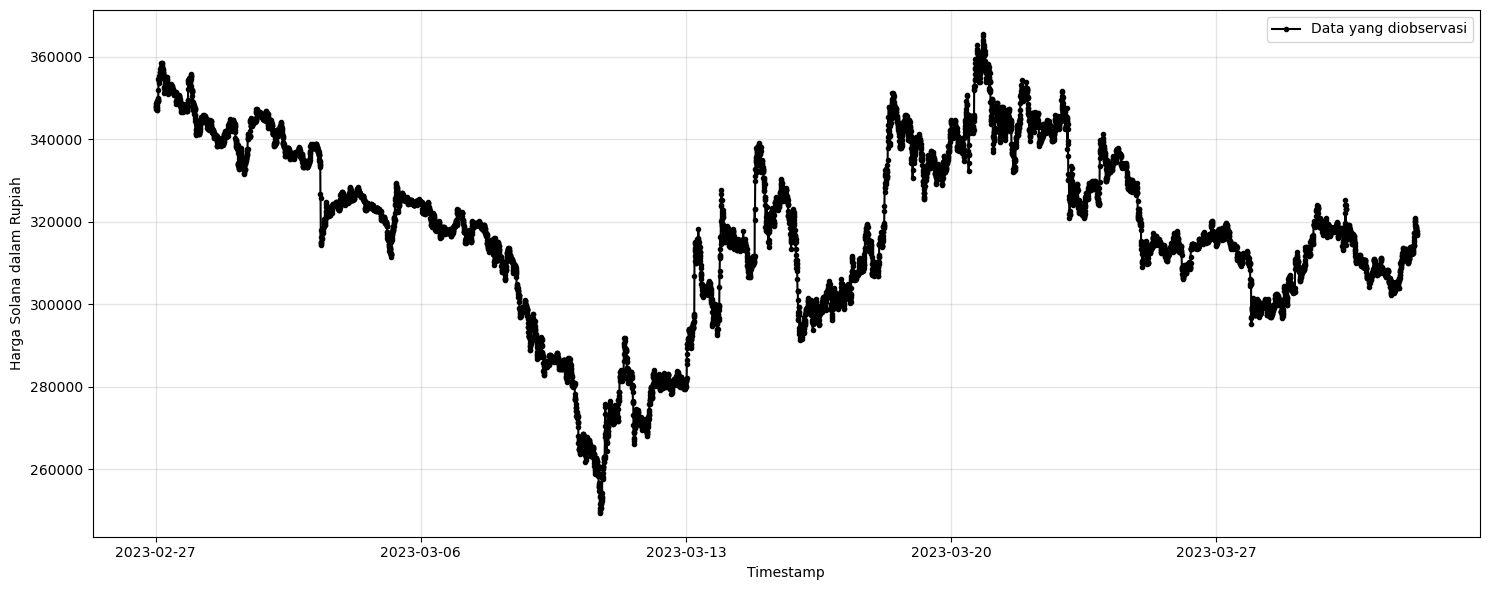

In [8]:
#Plot data latih keseluruhan
fig = plt.figure(facecolor='w', figsize=(15, 6))
ax = fig.add_subplot(111)
ax.plot(data_latih['ds'].dt.to_pydatetime(), data_latih['y'], 'k.', 
        ls='-', label='Data yang diobservasi')
locator = AutoDateLocator(interval_multiples=False)
formatter = AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Harga Solana dalam Rupiah')
ax.legend()
fig.tight_layout()
plt.savefig('Plot_Data_Train.png', dpi=288)

In [9]:
'''
Diinisiasi 4 model:
Model 1: Mingguan (+) Harian (+)
Model 2: Mingguan (*) Harian (*)
Model 3: Mingguan (+) Harian (*)
Model 4: Mingguan (*) Harian (+)

Parameter:
    fourier_order: 5
    n_changepoint: 25
'''

model1 = Prophet(weekly_seasonality=5, daily_seasonality=5, 
                 seasonality_mode='additive')
model2 = Prophet(weekly_seasonality=5, daily_seasonality=5, 
                 seasonality_mode='multiplicative')
model3 = Prophet().add_seasonality(name='weekly', period=7, 
                                   fourier_order=5, 
                                   mode='additive').add_seasonality(name='daily', period=1, 
                                                                    fourier_order=5, 
                                                                    mode='multiplicative')
model4 = Prophet().add_seasonality(name='weekly', period=7, fourier_order=5, 
                                   mode='multiplicative').add_seasonality(name='daily', period=1,
                                                                          fourier_order=5, 
                                                                          mode='additive')

models = [model1, model2, model3, model4]

In [10]:
for i, model in list(enumerate(models)):
    model.fit(data_latih)
    future = model.make_future_dataframe(periods=len(data_uji), 
                                         freq='5T', include_history=True)
    forecast = model.predict(future)
    ev = evaluasi_model(data_latih, data_uji, forecast, n)
    print('Model {0}'.format(i+1))
    print(ev)

Model 1
               Latih           Uji
0   MAE  3588.814085  34167.254390
1  MAPE     0.011338      0.110397
Model 2
               Latih           Uji
0   MAE  3604.665463  34146.801285
1  MAPE     0.011397      0.110327
Model 3
               Latih           Uji
0   MAE  3589.539654  34167.796304
1  MAPE     0.011343      0.110396
Model 4
               Latih           Uji
0   MAE  3612.106907  34162.077807
1  MAPE     0.011418      0.110379


In [11]:
#Menggunakan model 2, yaitu model multiplikatif sebagai model utama
'''Penyesuaian n_changepoint: [3,30]'''

n_change = []
MAE_latih_nchange = []
MAE_uji_nchange = []
MAPE_latih_nchange = []
MAPE_uji_nchange = []
et_nchange = []

for i in range(3,31):
    model = Prophet(n_changepoints=i, weekly_seasonality=5, 
                    daily_seasonality=5, seasonality_mode='multiplicative')
    start = time.time()
    model.fit(data_latih)
    future = model.make_future_dataframe(periods=len(data_uji), 
                                         freq='5T', include_history=True)
    forecast = model.predict(future)
    end = time.time()
    ev = evaluasi_model(data_latih, data_uji, forecast, n)
    n_change.append(i)
    MAE_latih_nchange.append(ev['Latih'][0])
    MAE_uji_nchange.append(ev['Uji'][0])
    MAPE_latih_nchange.append(ev['Latih'][1])
    MAPE_uji_nchange.append(ev['Uji'][1])
    et = round(end - start, 2)
    et_nchange.append(et)
    print("n_changepoint={0} selesai dievaluasi ({1} s)".format(i, et))

n_changepoint=3 selesai dievaluasi (6.0 s)
n_changepoint=4 selesai dievaluasi (7.26 s)
n_changepoint=5 selesai dievaluasi (7.83 s)
n_changepoint=6 selesai dievaluasi (9.18 s)
n_changepoint=7 selesai dievaluasi (13.76 s)
n_changepoint=8 selesai dievaluasi (20.46 s)
n_changepoint=9 selesai dievaluasi (22.5 s)
n_changepoint=10 selesai dievaluasi (23.92 s)
n_changepoint=11 selesai dievaluasi (29.35 s)
n_changepoint=12 selesai dievaluasi (37.28 s)
n_changepoint=13 selesai dievaluasi (28.92 s)
n_changepoint=14 selesai dievaluasi (30.04 s)
n_changepoint=15 selesai dievaluasi (46.67 s)
n_changepoint=16 selesai dievaluasi (39.63 s)
n_changepoint=17 selesai dievaluasi (50.13 s)
n_changepoint=18 selesai dievaluasi (52.02 s)
n_changepoint=19 selesai dievaluasi (59.31 s)
n_changepoint=20 selesai dievaluasi (71.58 s)
n_changepoint=21 selesai dievaluasi (59.53 s)
n_changepoint=22 selesai dievaluasi (95.39 s)
n_changepoint=23 selesai dievaluasi (109.49 s)
n_changepoint=24 selesai dievaluasi (104.41 s)

In [12]:
'''Penyesuaian fourier_order (weekly): [1,20]'''

fo_week = []
MAE_latih_foweek = []
MAE_uji_foweek = []
MAPE_latih_foweek = []
MAPE_uji_foweek = []
et_foweek = []

for i in range(1,21):
    model = Prophet(weekly_seasonality=i, daily_seasonality=5, 
                    seasonality_mode='multiplicative')
    start = time.time()
    model.fit(data_latih)
    future = model.make_future_dataframe(periods=len(data_uji), 
                                         freq='5T', include_history=True)
    forecast = model.predict(future)
    end = time.time()
    ev = evaluasi_model(data_latih, data_uji, forecast, n)
    fo_week.append(i)
    MAE_latih_foweek.append(ev['Latih'][0])
    MAE_uji_foweek.append(ev['Uji'][0])
    MAPE_latih_foweek.append(ev['Latih'][1])
    MAPE_uji_foweek.append(ev['Uji'][1])
    et = round(end - start, 2)
    et_foweek.append(et)
    print("fourier_order(weekly)={0} selesai dievaluasi ({1} s)".format(i, et))

fourier_order(weekly)=1 selesai dievaluasi (60.85 s)
fourier_order(weekly)=2 selesai dievaluasi (72.1 s)
fourier_order(weekly)=3 selesai dievaluasi (88.46 s)
fourier_order(weekly)=4 selesai dievaluasi (84.04 s)
fourier_order(weekly)=5 selesai dievaluasi (92.72 s)
fourier_order(weekly)=6 selesai dievaluasi (108.38 s)
fourier_order(weekly)=7 selesai dievaluasi (110.95 s)
fourier_order(weekly)=8 selesai dievaluasi (128.55 s)
fourier_order(weekly)=9 selesai dievaluasi (137.9 s)
fourier_order(weekly)=10 selesai dievaluasi (138.96 s)
fourier_order(weekly)=11 selesai dievaluasi (110.04 s)
fourier_order(weekly)=12 selesai dievaluasi (157.2 s)
fourier_order(weekly)=13 selesai dievaluasi (128.72 s)
fourier_order(weekly)=14 selesai dievaluasi (128.65 s)
fourier_order(weekly)=15 selesai dievaluasi (147.45 s)
fourier_order(weekly)=16 selesai dievaluasi (126.74 s)
fourier_order(weekly)=17 selesai dievaluasi (89.92 s)
fourier_order(weekly)=18 selesai dievaluasi (149.76 s)
fourier_order(weekly)=19 sel

In [13]:
'''Penyesuaian fourier_order (daily): [1,20]'''

fo_day = []
MAE_latih_foday = []
MAE_uji_foday = []
MAPE_latih_foday = []
MAPE_uji_foday = []
et_foday = []

for i in range(1,21):
    model = Prophet(weekly_seasonality=5, daily_seasonality=i, 
                    seasonality_mode='multiplicative')
    start = time.time()
    model.fit(data_latih)
    future = model.make_future_dataframe(periods=len(data_uji), 
                                         freq='5T', include_history=True)
    forecast = model.predict(future)
    end = time.time()
    ev = evaluasi_model(data_latih, data_uji, forecast, n)
    fo_day.append(i)
    MAE_latih_foday.append(ev['Latih'][0])
    MAE_uji_foday.append(ev['Uji'][0])
    MAPE_latih_foday.append(ev['Latih'][1])
    MAPE_uji_foday.append(ev['Uji'][1])
    et = round(end - start, 2)
    et_foday.append(et)
    print("fourier_order(daily)={0} selesai dievaluasi ({1} s)".format(i, et))

fourier_order(daily)=1 selesai dievaluasi (87.98 s)
fourier_order(daily)=2 selesai dievaluasi (80.47 s)
fourier_order(daily)=3 selesai dievaluasi (92.88 s)
fourier_order(daily)=4 selesai dievaluasi (1645.3 s)
fourier_order(daily)=5 selesai dievaluasi (92.23 s)
fourier_order(daily)=6 selesai dievaluasi (101.21 s)
fourier_order(daily)=7 selesai dievaluasi (107.85 s)
fourier_order(daily)=8 selesai dievaluasi (111.72 s)
fourier_order(daily)=9 selesai dievaluasi (97.93 s)
fourier_order(daily)=10 selesai dievaluasi (94.28 s)
fourier_order(daily)=11 selesai dievaluasi (102.02 s)
fourier_order(daily)=12 selesai dievaluasi (119.85 s)
fourier_order(daily)=13 selesai dievaluasi (85.1 s)
fourier_order(daily)=14 selesai dievaluasi (111.0 s)
fourier_order(daily)=15 selesai dievaluasi (105.26 s)
fourier_order(daily)=16 selesai dievaluasi (123.43 s)
fourier_order(daily)=17 selesai dievaluasi (121.3 s)
fourier_order(daily)=18 selesai dievaluasi (139.73 s)
fourier_order(daily)=19 selesai dievaluasi (142

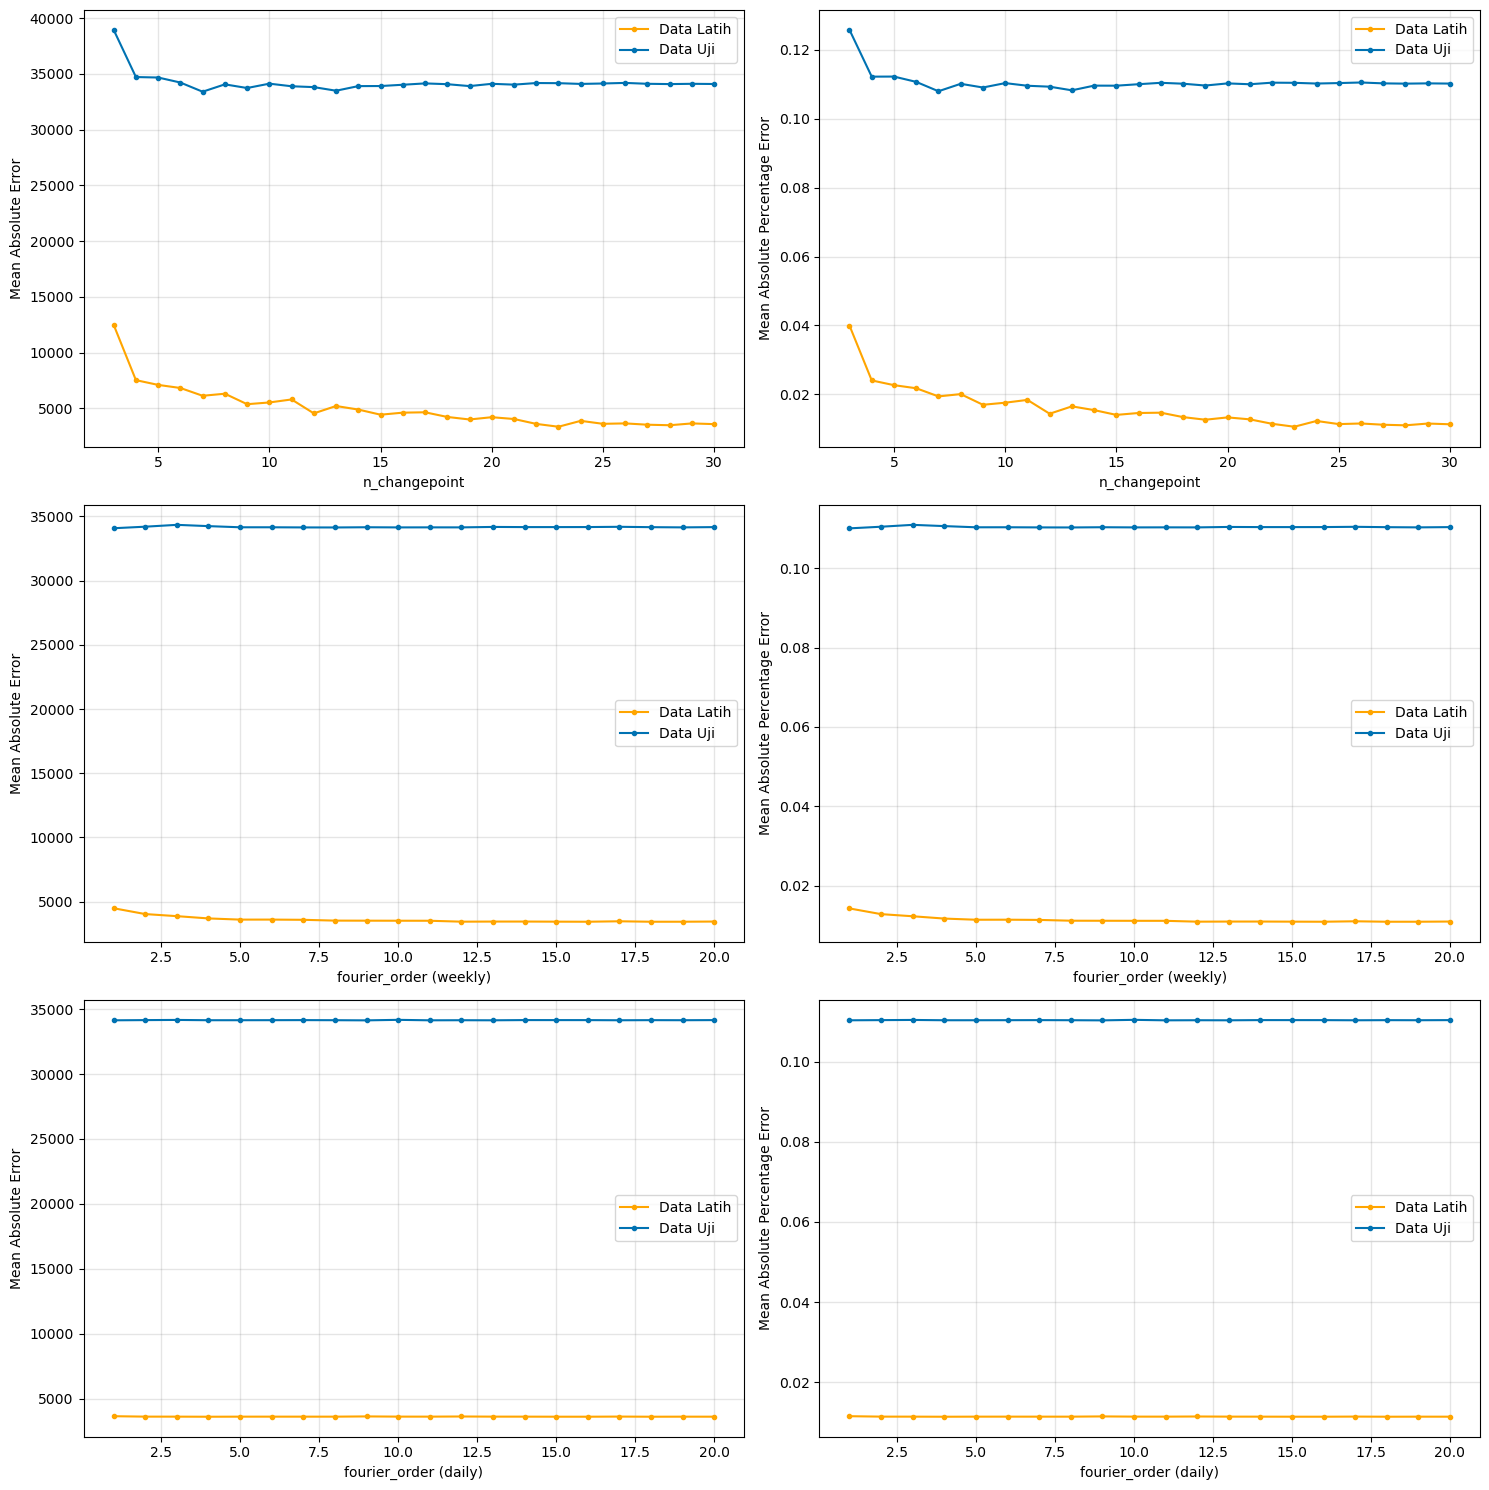

In [14]:
fig = plt.figure(facecolor='w', figsize=(15, 15))

ax = fig.add_subplot(321)
ax.plot(n_change, MAE_latih_nchange, 'k.', ls='-', c='orange', label='Data Latih')
ax.plot(n_change, MAE_uji_nchange, 'k.', ls='-', c='#0072B2', label='Data Uji')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('n_changepoint')
ax.set_ylabel('Mean Absolute Error')
ax.legend()
fig.tight_layout()

ax = fig.add_subplot(322)
ax.plot(n_change, MAPE_latih_nchange, 'k.', ls='-', c='orange', label='Data Latih')
ax.plot(n_change, MAPE_uji_nchange, 'k.', ls='-', c='#0072B2', label='Data Uji')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('n_changepoint')
ax.set_ylabel('Mean Absolute Percentage Error')
ax.legend()
fig.tight_layout()

ax = fig.add_subplot(323)
ax.plot(fo_week, MAE_latih_foweek, 'k.', ls='-', c='orange', label='Data Latih')
ax.plot(fo_week, MAE_uji_foweek, 'k.', ls='-', c='#0072B2', label='Data Uji')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('fourier_order (weekly)')
ax.set_ylabel('Mean Absolute Error')
ax.legend()
fig.tight_layout()

ax = fig.add_subplot(324)
ax.plot(fo_week, MAPE_latih_foweek, 'k.', ls='-', c='orange', label='Data Latih')
ax.plot(fo_week, MAPE_uji_foweek, 'k.', ls='-', c='#0072B2', label='Data Uji')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('fourier_order (weekly)')
ax.set_ylabel('Mean Absolute Percentage Error')
ax.legend()
fig.tight_layout()

ax = fig.add_subplot(325)
ax.plot(fo_day, MAE_latih_foday, 'k.', ls='-', c='orange', label='Data Latih')
ax.plot(fo_day, MAE_uji_foday, 'k.', ls='-', c='#0072B2', label='Data Uji')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('fourier_order (daily)')
ax.set_ylabel('Mean Absolute Error')
ax.legend()
fig.tight_layout()

ax = fig.add_subplot(326)
ax.plot(fo_day, MAPE_latih_foday, 'k.', ls='-', c='orange', label='Data Latih')
ax.plot(fo_day, MAPE_uji_foday, 'k.', ls='-', c='#0072B2', label='Data Uji')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('fourier_order (daily)')
ax.set_ylabel('Mean Absolute Percentage Error')
ax.legend()
fig.tight_layout()
plt.savefig('Hyperparameter_Tuning_1.png', dpi=288)

In [15]:
pd.DataFrame({'n_change':n_change, 'MAPE Latih' : MAPE_latih_nchange, 'MAPE uji' : MAPE_uji_nchange})

,n_change,MAPE Latih,MAPE uji
0,3,0.039977,0.125768
1,4,0.024067,0.112190
2,5,0.022693,0.112215
3,6,0.021793,0.110671
4,7,0.019430,0.107955
5,8,0.020097,0.110113
6,9,0.017002,0.109041
7,10,0.017602,0.110314
8,11,0.018416,0.109551
9,12,0.014403,0.109280


In [16]:
pd.DataFrame({'fo_week':fo_week, 'MAPE Latih Week' : MAPE_latih_foweek,
              'MAPE uji  Week' : MAPE_uji_foweek, 'fo_day':fo_day, 
              'MAPE Latih Day' : MAPE_latih_foday, 'MAPE uji Day' : MAPE_uji_foday})

,fo_week,MAPE Latih Week,MAPE uji Week,fo_day,MAPE Latih Day,MAPE uji Day
0,1,0.014244,0.110059,1,0.011509,0.110312
1,2,0.012810,0.110470,2,0.011403,0.110356
2,3,0.012273,0.110944,3,0.011399,0.110400
3,4,0.011691,0.110627,4,0.011376,0.110324
4,5,0.011397,0.110327,5,0.011397,0.110327
5,6,0.011406,0.110334,6,0.011399,0.110340
6,7,0.011353,0.110299,7,0.011397,0.110356
7,8,0.011153,0.110284,8,0.011395,0.110333
8,9,0.011139,0.110341,9,0.011456,0.110295
9,10,0.011126,0.110299,10,0.011406,0.110425


In [18]:
#Tidak banyak perubahan pada nilai MAE dan MAPE pada orde deret Fourier. 
#Selanjutnya akan dilakukan penyesuaian hyperparameter secara simultan berdasarkan hasil sebelumnya
#n_changepoint: [10,15], fourier_order(weekly): [1,5], fourier_order(daily): [1,5]

n_change2 = []
fo_week2 = []
fo_day2 = []
MAE_latih_sim = []
MAE_uji_sim = []
MAPE_latih_sim = []
MAPE_uji_sim = []
et_sim = []

for i in range(10,16):
    for j in range(1,6):
        for k in range(1,6):
            model = Prophet(n_changepoints=i, weekly_seasonality=j, 
                            daily_seasonality=k, seasonality_mode='multiplicative')
            start = time.time()
            model.fit(data_latih)
            future = model.make_future_dataframe(periods=len(data_uji), 
                                                 freq='5T', include_history=True)
            forecast = model.predict(future)
            end = time.time()
            ev = evaluasi_model(data_latih, data_uji, forecast, n)
            n_change2.append(i)
            fo_week2.append(j)
            fo_day2.append(k)
            MAE_latih_sim.append(ev['Latih'][0])
            MAE_uji_sim.append(ev['Uji'][0])
            MAPE_latih_sim.append(ev['Latih'][1])
            MAPE_uji_sim.append(ev['Uji'][1])
            et = round(end - start, 2)
            et_sim.append(et)
            print("n_changepoints={0}, fourier_order(weekly)={1},fourier_order(daily)={2} selesai dievaluasi ({3} s)".format(i, j, k, et))

n_changepoints=10, fourier_order(weekly)=1,fourier_order(daily)=1 selesai dievaluasi (18.09 s)
n_changepoints=10, fourier_order(weekly)=1,fourier_order(daily)=2 selesai dievaluasi (17.44 s)
n_changepoints=10, fourier_order(weekly)=1,fourier_order(daily)=3 selesai dievaluasi (18.47 s)
n_changepoints=10, fourier_order(weekly)=1,fourier_order(daily)=4 selesai dievaluasi (21.19 s)
n_changepoints=10, fourier_order(weekly)=1,fourier_order(daily)=5 selesai dievaluasi (20.92 s)
n_changepoints=10, fourier_order(weekly)=2,fourier_order(daily)=1 selesai dievaluasi (19.59 s)
n_changepoints=10, fourier_order(weekly)=2,fourier_order(daily)=2 selesai dievaluasi (17.81 s)
n_changepoints=10, fourier_order(weekly)=2,fourier_order(daily)=3 selesai dievaluasi (22.72 s)
n_changepoints=10, fourier_order(weekly)=2,fourier_order(daily)=4 selesai dievaluasi (20.21 s)
n_changepoints=10, fourier_order(weekly)=2,fourier_order(daily)=5 selesai dievaluasi (23.04 s)
n_changepoints=10, fourier_order(weekly)=3,fourier

In [19]:
hyper_sim_ungroup = pd.DataFrame({'fo_day' : fo_day2, 
                          'fo_week' : fo_week2, 
                          'n_changepoints' : n_change2,
                          'MAE_Latih' : MAE_latih_sim, 
                          'MAE_Uji' :MAE_uji_sim, 
                          'MAPE_Latih' : MAPE_latih_sim, 
                          'MAPE_Uji' : MAPE_uji_sim, 
                          'Elapsed_Time' : et_sim})
hyper_sim = hyper_sim_ungroup.groupby(['fo_day', 'fo_week'])

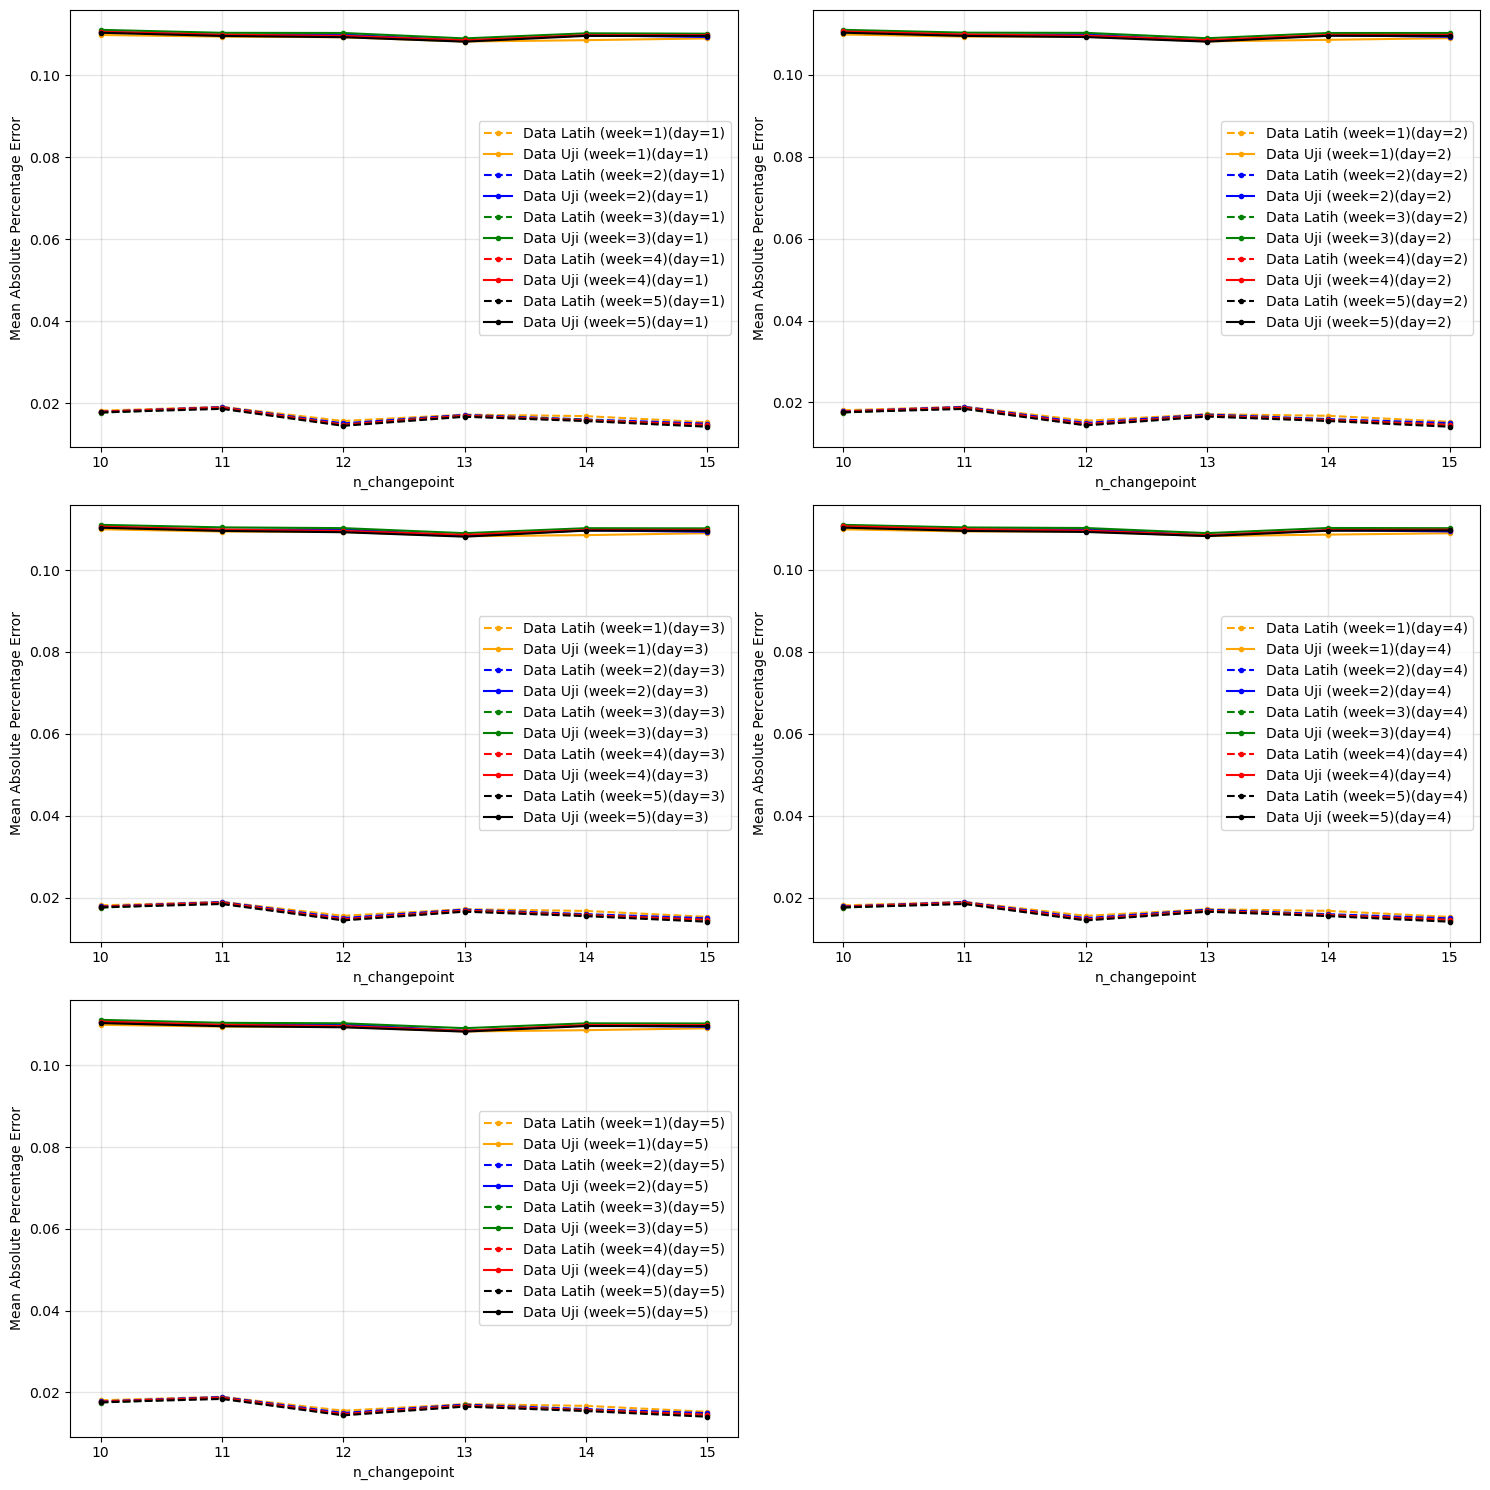

In [20]:
fig = plt.figure(facecolor='w', figsize=(15, 15))
colors = ['orange', 'blue', 'green', 'red', 'black']

for j in range(5):
    ax = fig.add_subplot(3, 2, j+1)
    for i, color in list(enumerate(colors)):
        ax.plot(hyper_sim.get_group((j+1,i+1))['n_changepoints'], 
                hyper_sim.get_group((j+1,i+1))['MAPE_Latih'],'k.', ls='--', 
                c=color, label='Data Latih (week={0})(day={1})'.format(i+1, j+1))
        ax.plot(hyper_sim.get_group((j+1,i+1))['n_changepoints'],
                hyper_sim.get_group((j+1,i+1))['MAPE_Uji'], 'k.', ls='-',
                c=color, label='Data Uji (week={0})(day={1})'.format(i+1, j+1))
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('n_changepoint')
    ax.set_ylabel('Mean Absolute Percentage Error')
    ax.legend()
    fig.tight_layout()

plt.savefig('Hyperparameter_Tuning_2.png', dpi=288)

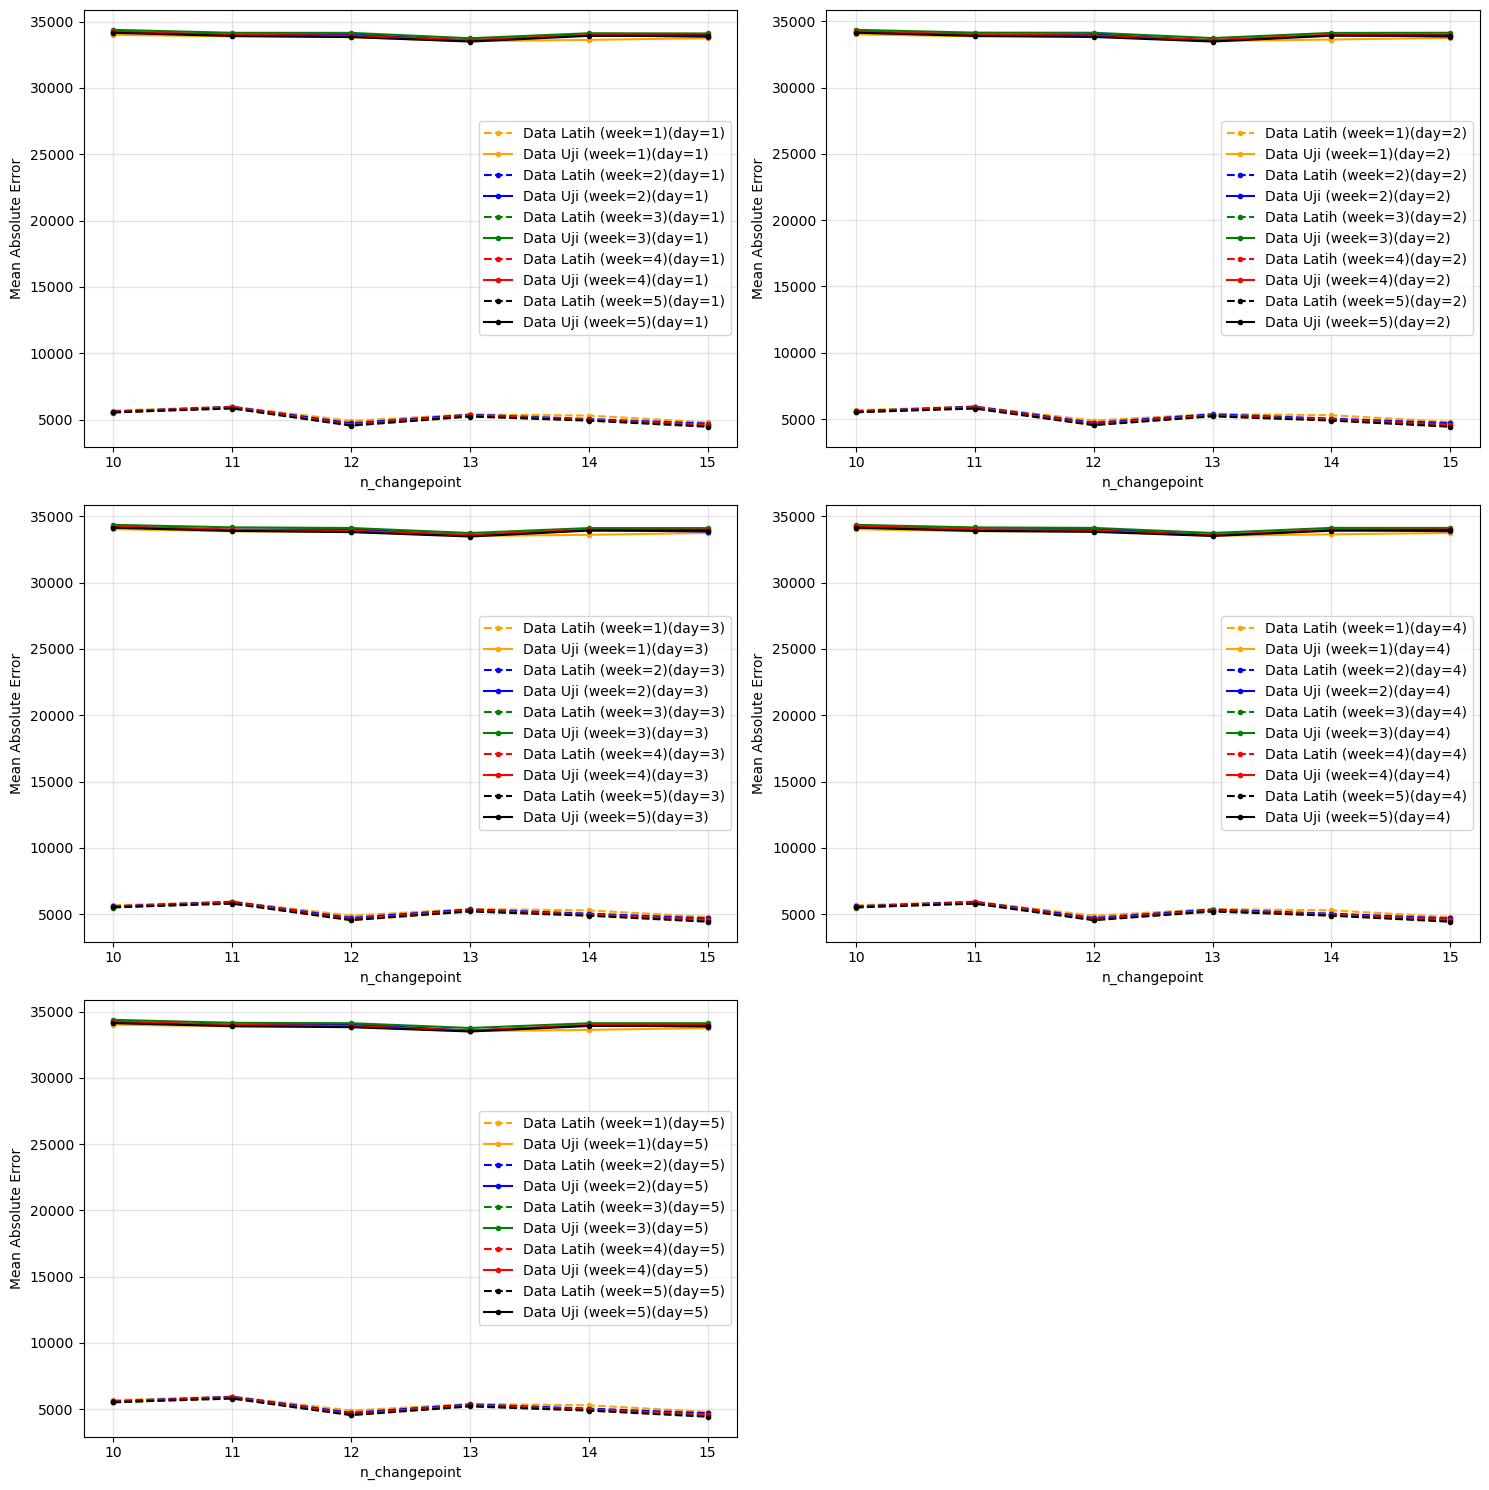

In [21]:
fig = plt.figure(facecolor='w', figsize=(15, 15))
colors = ['orange', 'blue', 'green', 'red', 'black']

for j in range(5):
    ax = fig.add_subplot(3, 2, j+1)
    for i, color in list(enumerate(colors)):
        ax.plot(hyper_sim.get_group((j+1,i+1))['n_changepoints'], 
                hyper_sim.get_group((j+1,i+1))['MAE_Latih'], 'k.', ls='--', 
                c=color, label='Data Latih (week={0})(day={1})'.format(i+1, j+1))
        ax.plot(hyper_sim.get_group((j+1,i+1))['n_changepoints'], 
                hyper_sim.get_group((j+1,i+1))['MAE_Uji'],'k.', ls='-', 
                c=color, label='Data Uji (week={0})(day={1})'.format(i+1, j+1))
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel('n_changepoint')
    ax.set_ylabel('Mean Absolute Error')
    ax.legend()
    fig.tight_layout()

plt.savefig('Hyperparameter_Tuning_3.png', dpi=288)

In [22]:
#Mengambil baris dengan nilai MAE/MAPE terkecil
hyper_sim_ungroup.loc[hyper_sim_ungroup['MAPE_Uji'] == min(hyper_sim_ungroup['MAPE_Uji'])]

,fo_day,fo_week,n_changepoints,MAE_Latih,MAE_Uji,MAPE_Latih,MAPE_Uji,Elapsed_Time
96,2,5,13,5203.377744,33468.442134,0.01654,0.108128,28.26


In [24]:
'''
Dipilih model dengan MAE dan MAPE uji terkecil untuk selanjutnya dilakukan 
penyesuaian pada hyperparameter seasonality_prior_scale dan changepoints_prior_scale
seasonality_prior_scale= [0.01, 0.1, 1, 10], changepoints_prior_scale= [0.01:0.15]
fourier_order(daily)=2, fourier_order(weekly)=5, n_changepoints= 13
'''

change_prior = [i*0.01 for i in range(1,16)]
season_prior = [0.01, 0.1, 1, 10]

c_prior = []
s_prior = []
MAE_latih_sim2 = []
MAE_uji_sim2 = []
MAPE_latih_sim2 = []
MAPE_uji_sim2 = []
et_sim2 = []

for i in change_prior:
    for j in season_prior:
        model = Prophet(n_changepoints=13, weekly_seasonality=5, 
                        daily_seasonality=2, seasonality_mode='multiplicative', 
                        seasonality_prior_scale=j, changepoint_prior_scale=i)
        start = time.time()
        model.fit(data_latih)
        future = model.make_future_dataframe(periods=len(data_uji), 
                                             freq='5T', include_history=True)
        forecast = model.predict(future)
        end = time.time()
        ev = evaluasi_model(data_latih, data_uji, forecast, n)
        c_prior.append(i)
        s_prior.append(j)
        MAE_latih_sim2.append(ev['Latih'][0])
        MAE_uji_sim2.append(ev['Uji'][0])
        MAPE_latih_sim2.append(ev['Latih'][1])
        MAPE_uji_sim2.append(ev['Uji'][1])
        et = round(end - start, 2)
        et_sim2.append(et)
        print("changepoints_prior_scale={0}, seasonality_prior_scale={1} selesai dievaluasi ({2} s)".format(i, j, et))

changepoints_prior_scale=0.01, seasonality_prior_scale=0.01 selesai dievaluasi (31.06 s)
changepoints_prior_scale=0.01, seasonality_prior_scale=0.1 selesai dievaluasi (36.94 s)
changepoints_prior_scale=0.01, seasonality_prior_scale=1 selesai dievaluasi (31.09 s)
changepoints_prior_scale=0.01, seasonality_prior_scale=10 selesai dievaluasi (39.01 s)
changepoints_prior_scale=0.02, seasonality_prior_scale=0.01 selesai dievaluasi (36.23 s)
changepoints_prior_scale=0.02, seasonality_prior_scale=0.1 selesai dievaluasi (35.64 s)
changepoints_prior_scale=0.02, seasonality_prior_scale=1 selesai dievaluasi (31.89 s)
changepoints_prior_scale=0.02, seasonality_prior_scale=10 selesai dievaluasi (32.67 s)
changepoints_prior_scale=0.03, seasonality_prior_scale=0.01 selesai dievaluasi (38.53 s)
changepoints_prior_scale=0.03, seasonality_prior_scale=0.1 selesai dievaluasi (36.3 s)
changepoints_prior_scale=0.03, seasonality_prior_scale=1 selesai dievaluasi (32.75 s)
changepoints_prior_scale=0.03, seasona

In [25]:
hyper_sim2_ungroup = pd.DataFrame({'change_prior' : c_prior, 
                          'season_prior' : s_prior, 
                          'MAE_Latih' : MAE_latih_sim2, 
                          'MAE_Uji' :MAE_uji_sim2, 
                          'MAPE_Latih' : MAPE_latih_sim2, 
                          'MAPE_Uji' : MAPE_uji_sim2, 
                          'Elapsed_Time' : et_sim2})
hyper_sim2 = hyper_sim2_ungroup.groupby(['season_prior'])

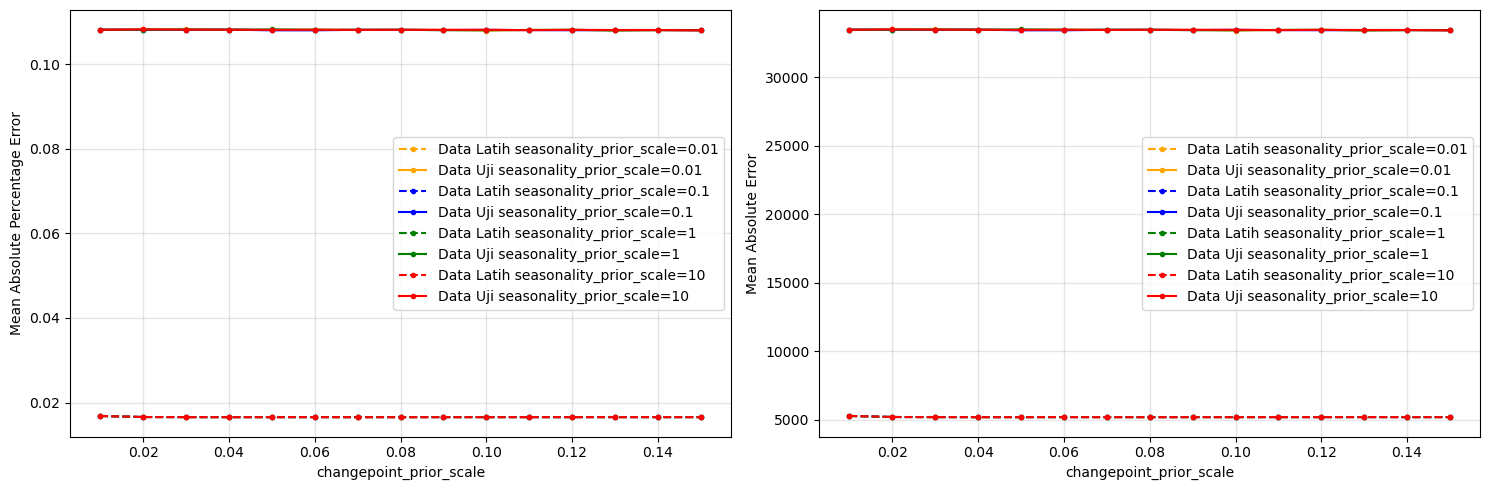

In [26]:
fig = plt.figure(facecolor='w', figsize=(15, 5))
colors = ['orange', 'blue', 'green', 'red']
cc = 0
ccc = 0

ax = fig.add_subplot(1, 2, 1)
for i in season_prior:
    ax.plot(hyper_sim2.get_group(i)['change_prior'], 
            hyper_sim2.get_group(i)['MAPE_Latih'], 'k.', ls='--', c=colors[cc], 
            label='Data Latih seasonality_prior_scale={0}'.format(i))
    ax.plot(hyper_sim2.get_group(i)['change_prior'], 
            hyper_sim2.get_group(i)['MAPE_Uji'], 'k.', ls='-', c=colors[cc], 
            label='Data Uji seasonality_prior_scale={0}'.format(i))
    cc+=1
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('changepoint_prior_scale')
ax.set_ylabel('Mean Absolute Percentage Error')
ax.legend()
fig.tight_layout()

ax = fig.add_subplot(1, 2, 2)
for i in season_prior:
    ax.plot(hyper_sim2.get_group(i)['change_prior'], 
            hyper_sim2.get_group(i)['MAE_Latih'], 'k.', ls='--', c=colors[ccc], 
            label='Data Latih seasonality_prior_scale={0}'.format(i))
    ax.plot(hyper_sim2.get_group(i)['change_prior'], 
            hyper_sim2.get_group(i)['MAE_Uji'], 'k.', ls='-', c=colors[ccc], 
            label='Data Uji seasonality_prior_scale={0}'.format(i))
    ccc+=1
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('changepoint_prior_scale')
ax.set_ylabel('Mean Absolute Error')
ax.legend()
fig.tight_layout()

plt.savefig('Hyperparameter_Tuning_4.png', dpi=288)

In [27]:
#Mengambil baris dengan nilai MAE/MAPE terkecil
hyper_sim2_ungroup.loc[hyper_sim2_ungroup['MAPE_Uji'] == min(hyper_sim2_ungroup['MAPE_Uji'])]

,change_prior,season_prior,MAE_Latih,MAE_Uji,MAPE_Latih,MAPE_Uji,Elapsed_Time
36,0.1,0.01,5205.380222,33423.957697,0.016546,0.107979,20.67


In [28]:
'''
Model multiplikatif dipilih dengan parameter n_changepoints= 13, fourier_order(daily)=2,
fourier_order(weekly)=5, seasonal_prior_scale=0.01, dan changepoint_prior_scale=0.1
'''
#Menaikkan range changepoint menjadi 100%
model_terbaik = Prophet(n_changepoints=13, weekly_seasonality=5, 
                        daily_seasonality=2, seasonality_mode='multiplicative', 
                        seasonality_prior_scale=0.01, changepoint_prior_scale=0.1)
model_terbaik.fit(data_latih)

In [29]:
future = model_terbaik.make_future_dataframe(periods=len(data_uji), 
                                             freq='5T', include_history=True)
forecast = model_terbaik.predict(future)
ev = evaluasi_model(data_latih, data_uji, forecast, n)
print(ev)

               Latih           Uji
0   MAE  5205.380222  33423.957697
1  MAPE     0.016546      0.107979


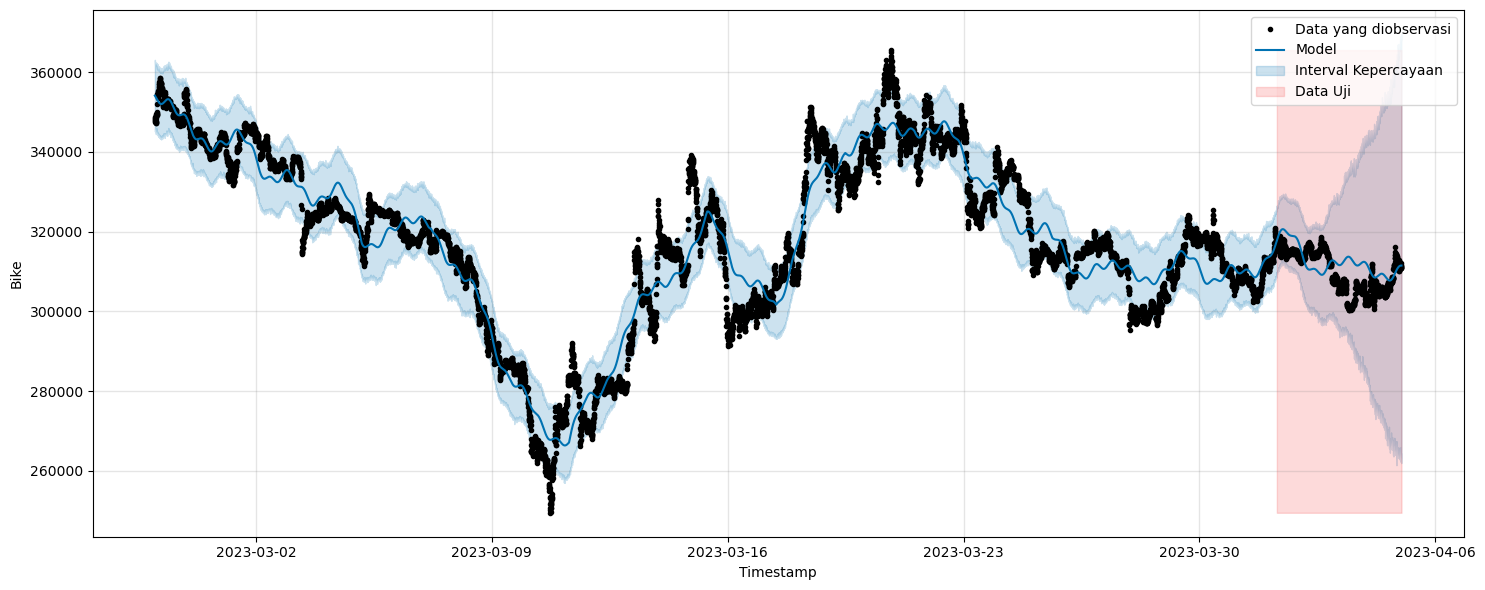

In [30]:
fig = plt.figure(facecolor='w', figsize=(15, 6))
ax = fig.add_subplot(111)
fcst_t = forecast['ds'].dt.to_pydatetime()
test_t = data_uji['ds'].dt.to_pydatetime()
ax.plot(data['ds'].dt.to_pydatetime(), data['y'], 'k.', label='Data yang diobservasi')
ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2', label='Model')
ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'], 
                color='#0072B2', alpha=0.2, label='Interval Kepercayaan')
ax.fill_between(test_t, min(min(data['y']), min(forecast['yhat'])), 
                max(max(data['y']), max(forecast['yhat'])), color='#F74A4A', 
                alpha=0.2, label='Data Uji')
locator = AutoDateLocator(interval_multiples=False)
formatter = AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Bike')
ax.legend()
fig.tight_layout()

plt.savefig('Fit_All.png', dpi=288)

In [31]:
#Peramalan
future = model_terbaik.make_future_dataframe(periods=len(data_uji)+12, 
                                             freq='5T', include_history=True)
forecast = model_terbaik.predict(future)

In [32]:
peramalan = forecast[-12:]
peramalan

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
10656,2023-04-05 00:00:00,312222.642088,266816.741345,361529.489051,267414.926989,364422.628524,0.001882,0.001882,0.001882,-0.002413,-0.002413,-0.002413,-0.004295,-0.004295,-0.004295,0.0,0.0,0.0,311469.105028
10657,2023-04-05 00:05:00,312223.105262,265022.637505,364199.876423,267347.183388,364490.116236,0.001745,0.001745,0.001745,-0.002427,-0.002427,-0.002427,-0.004172,-0.004172,-0.004172,0.0,0.0,0.0,311465.403625
10658,2023-04-05 00:10:00,312223.568436,264199.896239,362655.268198,267279.439787,364557.603948,0.001605,0.001605,0.001605,-0.002443,-0.002443,-0.002443,-0.004048,-0.004048,-0.004048,0.0,0.0,0.0,311460.912643
10659,2023-04-05 00:15:00,312224.031610,264336.772560,367061.780168,267211.696186,364625.091660,0.001462,0.001462,0.001462,-0.002461,-0.002461,-0.002461,-0.003923,-0.003923,-0.003923,0.0,0.0,0.0,311455.700528
10660,2023-04-05 00:20:00,312224.494784,263862.503042,365067.060028,267143.952585,364692.579371,0.001316,0.001316,0.001316,-0.002481,-0.002481,-0.002481,-0.003798,-0.003798,-0.003798,0.0,0.0,0.0,311449.837333
10661,2023-04-05 00:25:00,312224.957958,260545.135078,363828.405079,267076.208984,364760.067083,0.001169,0.001169,0.001169,-0.002503,-0.002503,-0.002503,-0.003672,-0.003672,-0.003672,0.0,0.0,0.0,311443.394587
10662,2023-04-05 00:30:00,312225.421132,264701.772524,363542.142525,267008.465384,364827.554795,0.001019,0.001019,0.001019,-0.002527,-0.002527,-0.002527,-0.003546,-0.003546,-0.003546,0.0,0.0,0.0,311436.445147
10663,2023-04-05 00:35:00,312225.884306,263626.120566,363061.481286,266940.721783,364895.042507,0.000867,0.000867,0.000867,-0.002552,-0.002552,-0.002552,-0.003419,-0.003419,-0.003419,0.0,0.0,0.0,311429.063061
10664,2023-04-05 00:40:00,312226.347480,265095.751211,366415.521610,266872.978182,364962.530219,0.000713,0.000713,0.000713,-0.002578,-0.002578,-0.002578,-0.003292,-0.003292,-0.003292,0.0,0.0,0.0,311421.323417
10665,2023-04-05 00:45:00,312226.810654,263693.811639,364153.978255,266805.234581,365030.017930,0.000559,0.000559,0.000559,-0.002606,-0.002606,-0.002606,-0.003164,-0.003164,-0.003164,0.0,0.0,0.0,311413.302203


In [33]:
fut = model_terbaik.make_future_dataframe(periods=len(data_uji)+12, freq='5T')
aktual = fut[-12:].reset_index()
del aktual['index']

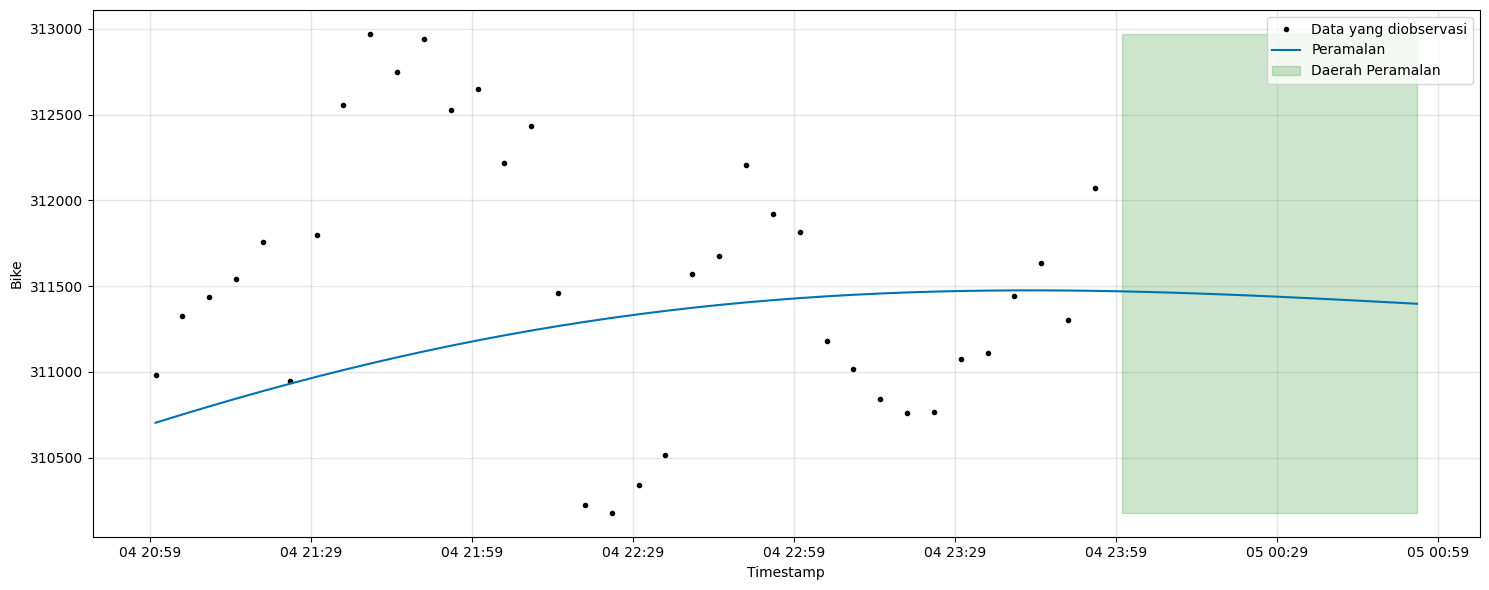

In [35]:
to_plot = forecast[-48:]

fig = plt.figure(facecolor='w', figsize=(15, 6))
ax = fig.add_subplot(111)
fcst_t = to_plot['ds'].dt.to_pydatetime()
test_t = to_plot['ds'][-12:].dt.to_pydatetime()
ax.plot(data_uji['ds'][-36:].dt.to_pydatetime(), data_uji['y'][-36:], 'k.', 
        label='Data yang diobservasi')
ax.plot(fcst_t, to_plot['yhat'], ls='-', c='#0072B2', label='Peramalan')
ax.fill_between(test_t, min(min(to_plot['yhat']), min(data_uji['y'][-36:])), 
                max(max(to_plot['yhat']), max(data_uji['y'][-36:])), 
                color='green', alpha=0.2, label='Daerah Peramalan')
locator = AutoDateLocator(interval_multiples=False)
formatter = AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Bike')
ax.legend()
fig.tight_layout()

plt.savefig('Forecast_WoInterval_Wonew.png', dpi=288)

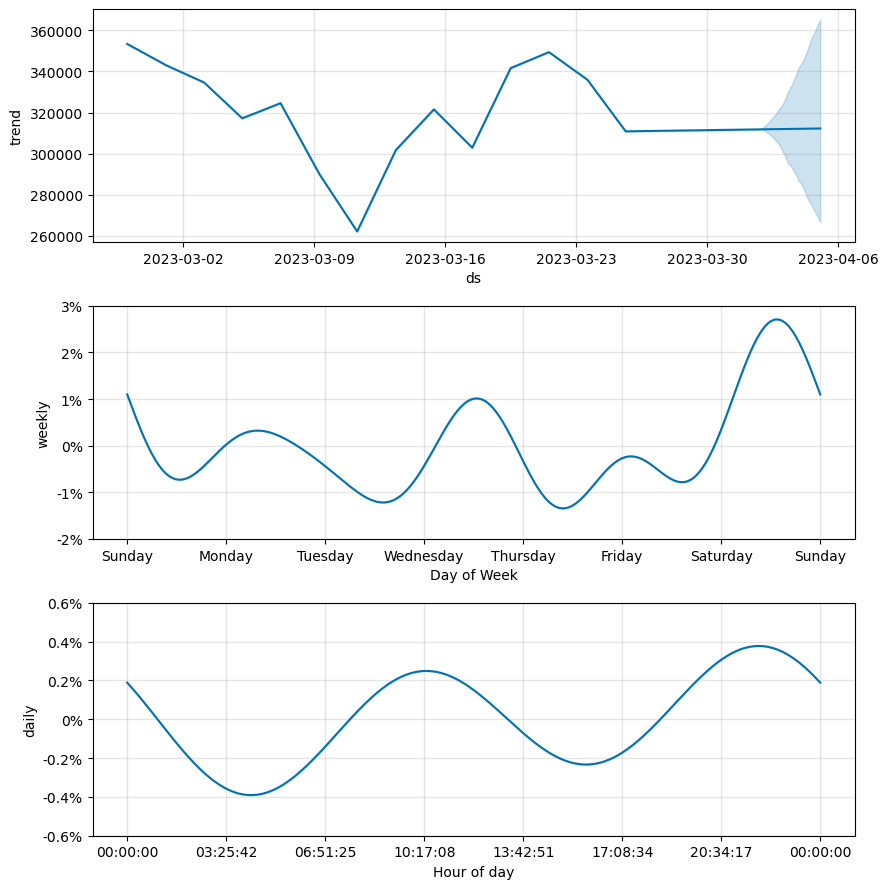

In [36]:
#Dekomposisi
fig = model_terbaik.plot_components(forecast)

plt.savefig('Decomposition.png', dpi=288)

In [37]:
model_terbaik.params

{'k': array([[-0.45600892]]),
 'm': array([[0.96667952]]),
 'delta': array([[ 0.08322762, -0.40729767,  1.10779274, -1.84290715,  0.25765534,
          3.0067516 , -0.86253704, -1.71497252,  2.54793603, -1.37250897,
         -0.93985892, -0.52778016,  1.13265885]]),
 'sigma_obs': array([[0.0178526]]),
 'beta': array([[ 0.00389027, -0.00503811, -0.00711963,  0.0011199 , -0.00149063,
          0.00637988, -0.00292675, -0.00641701, -0.00418566,  0.00060283,
         -0.00100017,  0.00019012, -0.0026017 ,  0.00169175]]),
 'trend': array([[0.96667952, 0.96663196, 0.96658441, ..., 0.85283064, 0.85283191,
         0.85283318]]),
 'Y': array([[0.96873034, 0.96861112, 0.96848843, ..., 0.86857841, 0.86884103,
         0.86910309]]),
 'beta_m': array([[ 0.00389027, -0.00503811, -0.00711963,  0.0011199 , -0.00149063,
          0.00637988, -0.00292675, -0.00641701, -0.00418566,  0.00060283,
         -0.00100017,  0.00019012, -0.0026017 ,  0.00169175]]),
 'beta_a': array([[ 0., -0., -0.,  0., -0.,  

In [40]:
gamma = -model_terbaik.changepoints_t*model_terbaik.params['delta']
gamma

array([[-0.0051209 ,  0.0501211 , -0.20448359,  0.45356772, -0.07926616,
        -1.11001154,  0.37158625,  0.84434094, -1.41120954,  0.84463192,
         0.63621068,  0.38973942, -0.90610345]])

In [42]:
print(model_terbaik.train_component_cols)

component  daily  multiplicative_terms  weekly  additive_terms
col                                                           
0              0                     1       1               0
1              0                     1       1               0
2              0                     1       1               0
3              0                     1       1               0
4              0                     1       1               0
5              0                     1       1               0
6              0                     1       1               0
7              0                     1       1               0
8              0                     1       1               0
9              0                     1       1               0
10             1                     1       0               0
11             1                     1       0               0
12             1                     1       0               0
13             1                     1       0         